In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from util import prep
from util import matlab_cca

In [28]:
# List of sessions
# sessions = ["M052_2025_01_23_15_15","M052_2025_01_24_15_00","M052_2025_01_25_14_30","M052_2025_01_27_15_00"]
# sessions = ["M051_2025_02_05_16_00","M051_2025_02_06_15_00","M051_2025_02_07_15_30","M051_2025_02_08_15_30","M051_2025_02_09_16_45","M051_2025_02_10_16_00","M051_2025_02_11_11_30","M051_2025_02_12_15_30","M051_2025_02_13_15_00","M051_2025_02_14_15_00"]
sessions = ["M056_2025_02_18_16_00","M056_2025_02_19_11_00","M056_2025_02_20_11_30","M056_2025_02_21_11_00","M056_2025_02_22_12_15","M056_2025_02_23_15_00","M056_2025_02_24_11_45","M056_2025_02_25_11_00","M056_2025_02_26_11_00","M056_2025_02_27_11_00","M056_2025_02_28_11_15"]

data_dir = 'C:/Users/Cecilia/data/raw'

# List to store logs for each session
session_logs = []

for session in sessions:
    animal = session[0:4]
    last_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_last_node.log')
    middle_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_middle_node1.log')
    save_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_save_node.log')
    main = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-Main.log')
    update_buffer = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_buffer.log')
    update_pca = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_pca.log')

    # Combine all DataFrames into one
    logs = pd.concat([last_node, middle_node, save_node, main, update_buffer, update_pca], ignore_index=True)
    logs = logs.sort_values(by='timestamp').reset_index(drop=True)
    #fix timestamp so that it starts with 0
    logs['timestamp'] = logs['timestamp'] - logs['timestamp'][0]   
    
    # Store the session name and logs in the list
    session_logs.append((session, logs))

# # Example usage: Access logs for each session
# for session, logs in session_logs:
#     print(f"Logs for {session}:")
#     display(logs)

In [29]:
cursor_all = []
time_cursor_all = []
bci_value_all = []
rewarded_bci_value_all = []
th_value_all = []
time_th_value_all = []
ccs_all = []
pca1_all = []
pca2_all = []

for session, logs in session_logs:

    # Get the cursor value (mean top 10 ccs)
    filtered_log = logs[logs['message'].str.contains('rolling cca sum=')]
    cursor = filtered_log['message'].str.extract(r'rolling cca sum=([0-9\.]+)')
    cursor = pd.to_numeric(cursor[0], errors='coerce')
    time_cursor = np.array(filtered_log['timestamp'])
    
    # Get the top 10 ccs values
    filtered_log = logs[logs['message'].str.contains('rolling cca sum=', na=False)]
    ccs = filtered_log['message'].str.extract(r'\[([^\]]+)\]')[0]
    ccs = [np.array(row.split(), dtype=float) for row in ccs.dropna()] 
    ccs_num =10
    ccs = np.array([np.pad(arr, (0, ccs_num - len(arr)), mode='constant', constant_values=1)
                         if len(arr) < ccs_num else arr[:ccs_num] for arr in ccs])
    
    # Get the pca weight matrices
    filtered_log = logs[logs['message'].str.contains(r'pca1_matrix=')]
    pca1 = filtered_log['message'].str.extract(r'pca1_matrix=(\[\[.*?\]\])')[0]
    pca1 = [np.array(eval(row)) for row in pca1]
    filtered_log = logs[logs['message'].str.contains(r'pca2_matrix=')]
    pca2 = filtered_log['message'].str.extract(r'pca2_matrix=(\[\[.*?\]\])')[0]
    pca2 = [np.array(eval(row)) for row in pca2] 
    
    # Get the threshold values
    filtered_log = logs[logs['message'].str.contains(r'Node2 PCA matrix/CCA threshold updated:')]
    th_change_value = filtered_log['message'].str.extract(r'new th=([0-9\.]+)')
    th_change_value = np.array(pd.to_numeric(th_change_value[0], errors='coerce'))
    time_th_change = filtered_log['timestamp']    
    # Fix the th values to be in each sample
    idx = np.searchsorted(time_th_change, time_cursor, side='right') - 1 # Find indices of the most recent change
    th_value = np.where(idx < 0, th_change_value[0], th_change_value[idx]) # If idx is -1 (before first change), set first th value

    # Get the bci output (0 or 1)
    filtered_log = logs[logs['message'].str.contains(r'cursor value')]
    bci_change_value = filtered_log['message'].str.extract(r'(\d)$')
    bci_change_value = np.array(pd.to_numeric(bci_change_value[0], errors='coerce'))
    time_bci_change = filtered_log['timestamp']
    # Fix the bci values to be in each sample
    idx = np.searchsorted(time_bci_change, time_cursor, side='right') - 1 # Find indices of the most recent change
    bci_value = np.where(idx < 0, 1 - bci_change_value[0], bci_change_value[idx]) # If idx is -1 (before first change), set to the opposite of the first change
   
    # Get rewarded times for a threshold of 200ms
    rewarded_hold = 0.4 #seconds
    n_rewarded_samples = rewarded_hold/0.04
    diff = np.diff(bci_value)
    start_indices = np.where(diff == 1)[0] + 1
    end_indices = np.where(diff == -1)[0] + 1
    if bci_value[0] == 1:
        start_indices = np.insert(start_indices, 0, 0)
    if bci_value[-1] == 1:
        end_indices = np.append(end_indices, len(bci_value))
    mask = np.zeros_like(bci_value, dtype=bool)
    for start, end in zip(start_indices, end_indices):
        if end - start >= n_rewarded_samples:
            mask[start] = True
    rewarded_bci_value = np.where(mask, bci_value, 0)
    
    # Save all
    cursor_all.append(cursor)
    time_cursor_all.append(time_cursor)
    bci_value_all.append(bci_value)
    rewarded_bci_value_all.append(rewarded_bci_value)
    th_value_all.append(th_value)
    ccs_all.append(ccs)
    pca1_all.append(pca1)
    pca2_all.append(pca2)

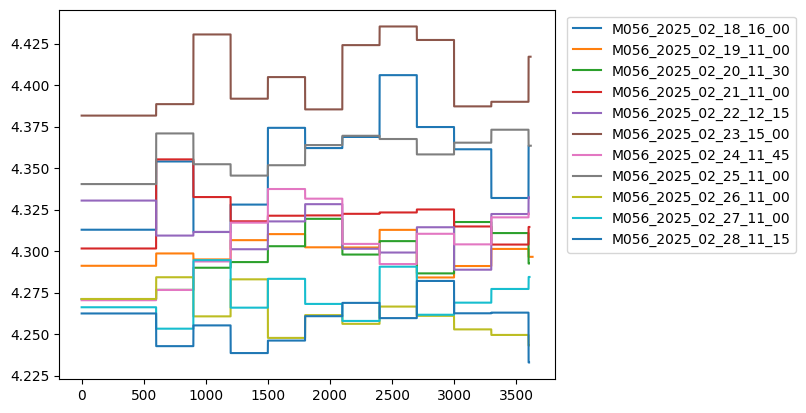

In [30]:
for session in range(len(sessions)):
    t = time_cursor_all[session]-time_cursor_all[session][0] # so all thresholds start at 0
    plt.plot(t,th_value_all[session], label=sessions[session])
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    
    # plt.ylim(4.2,5)

C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2116\1546282288.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=session_labels, y=values, inner="box", palette="coolwarm")


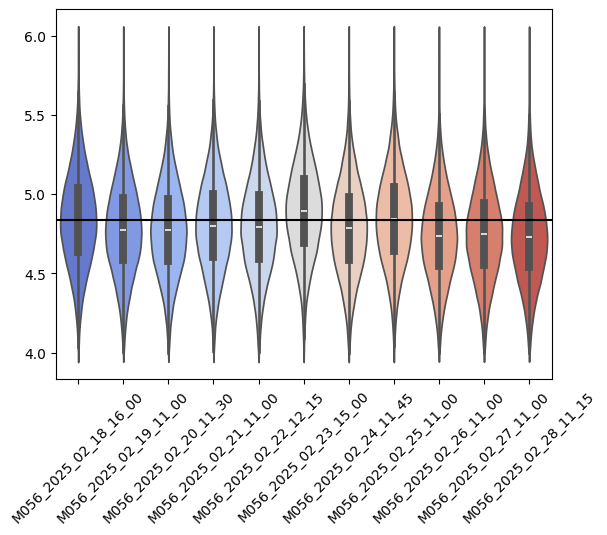

In [31]:
# Define filter range
lower_bound, upper_bound = 4, 6

filtered_cursor_all = [session[(session >= lower_bound) & (session <= upper_bound)] for session in cursor_all]
filtered_data = [(sessions[i], value) for i, session in enumerate(filtered_cursor_all) for value in session]

session_labels, values = zip(*filtered_data)

# Create a violin plot
# plt.figure(figsize=(10, 5))
sns.violinplot(x=session_labels, y=values, inner="box", palette="coolwarm")
plt.xticks(rotation=45)
plt.axhline(y=np.mean(cursor_all[0]),color='k')

plt.show()

Text(0.5, 0, 'Cursor value')

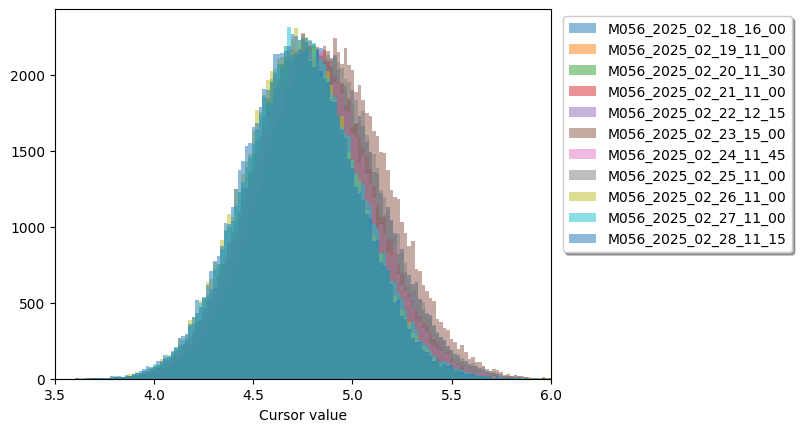

In [32]:
for session in range(len(sessions)):
    # if session <1:
    #     continue
    plt.hist(cursor_all[session], bins=505, alpha=0.5, label=sessions[session])
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', shadow=True)
    
    plt.xlim(3.5,6)
# plt.hist(cursor_all[0], bins=505,alpha=0.5);
# plt.hist(cursor_all[1], bins=505,alpha=0.5);
# plt.hist(cursor_all[2], bins=505,alpha=0.5);
# # plt.plot(np.cumsum(cursor_all[0]))

# plt.axvline(x=4.3,color='k')
plt.xlabel('Cursor value')

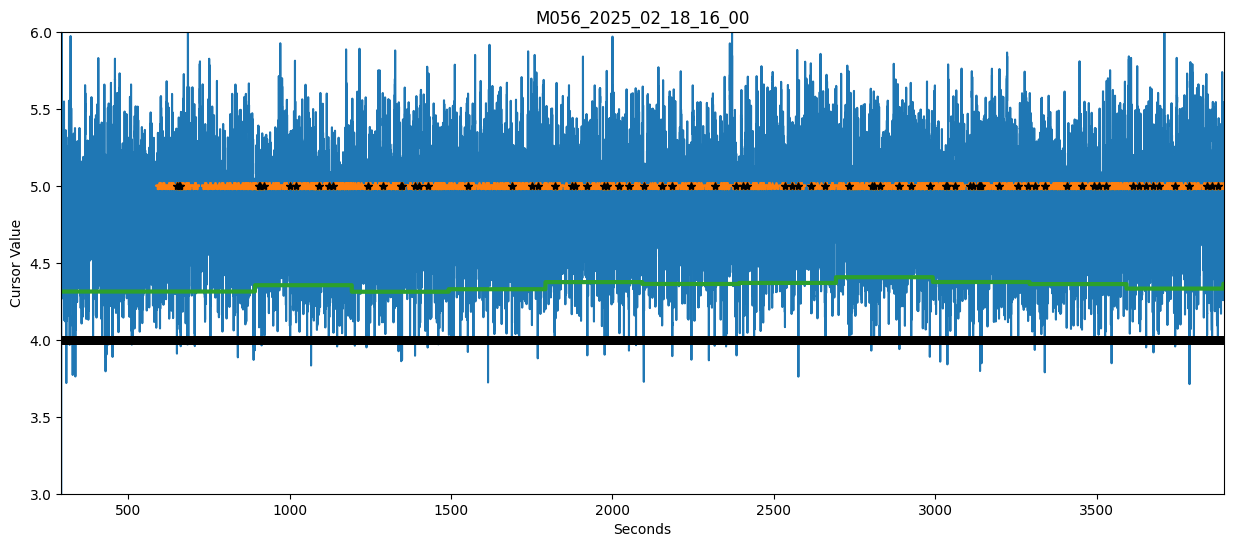

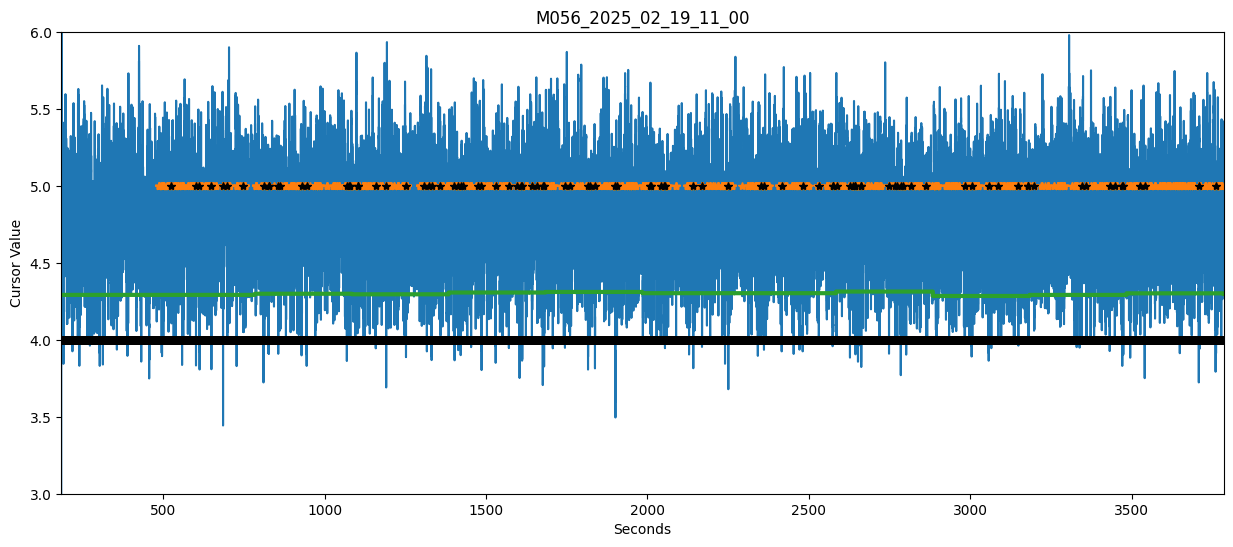

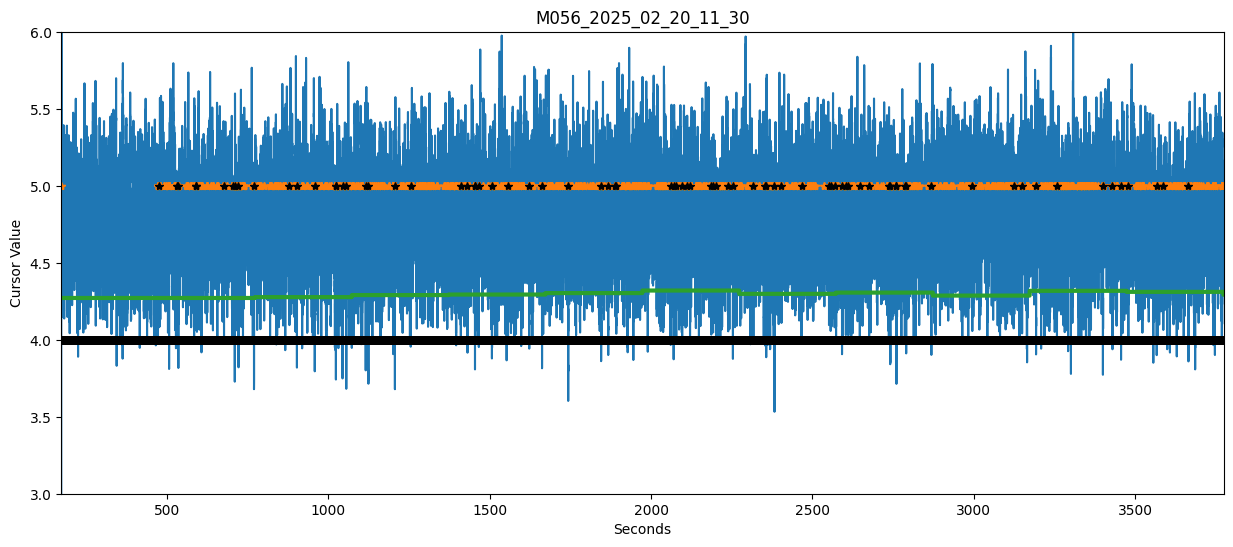

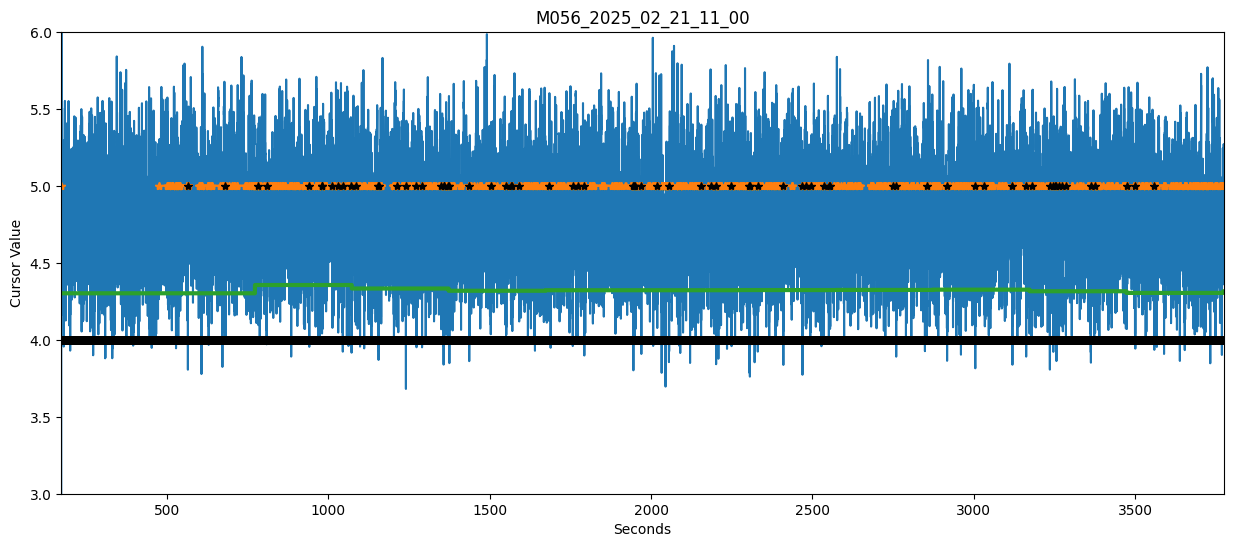

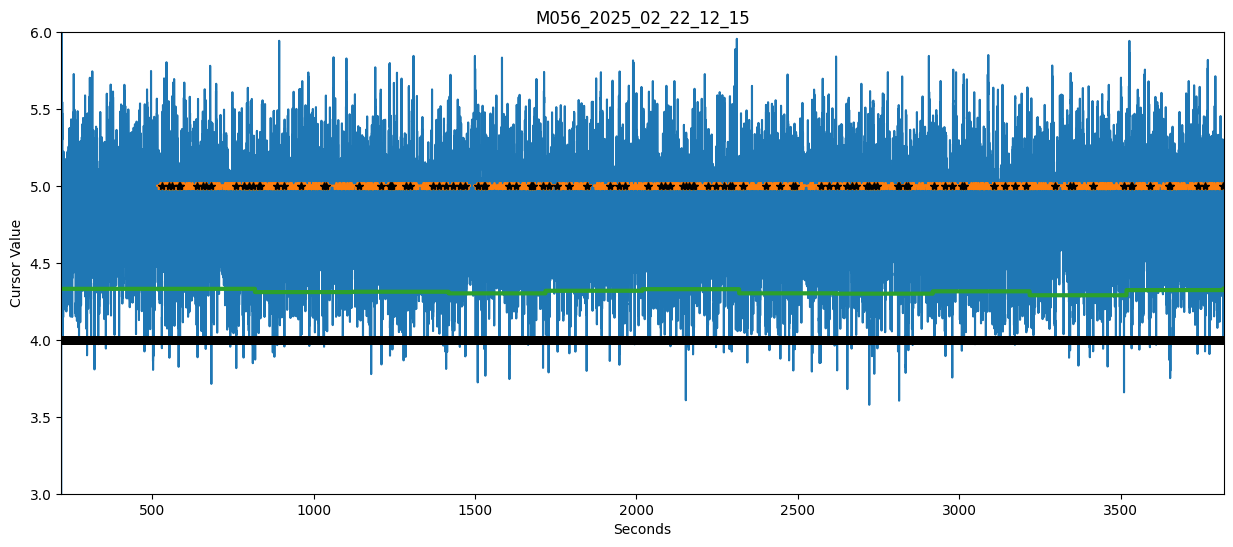

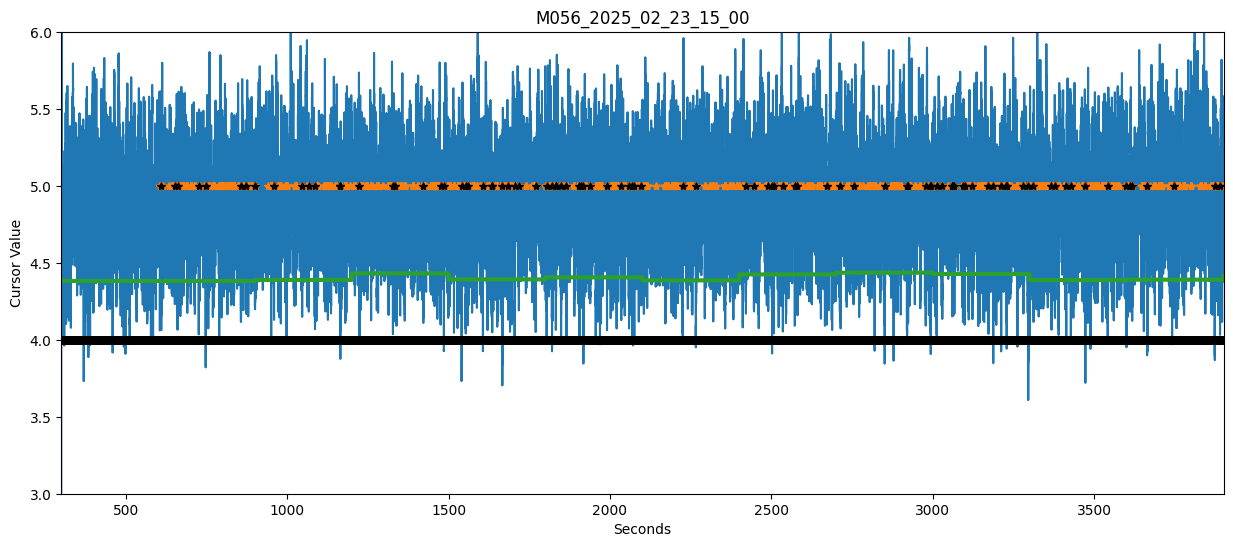

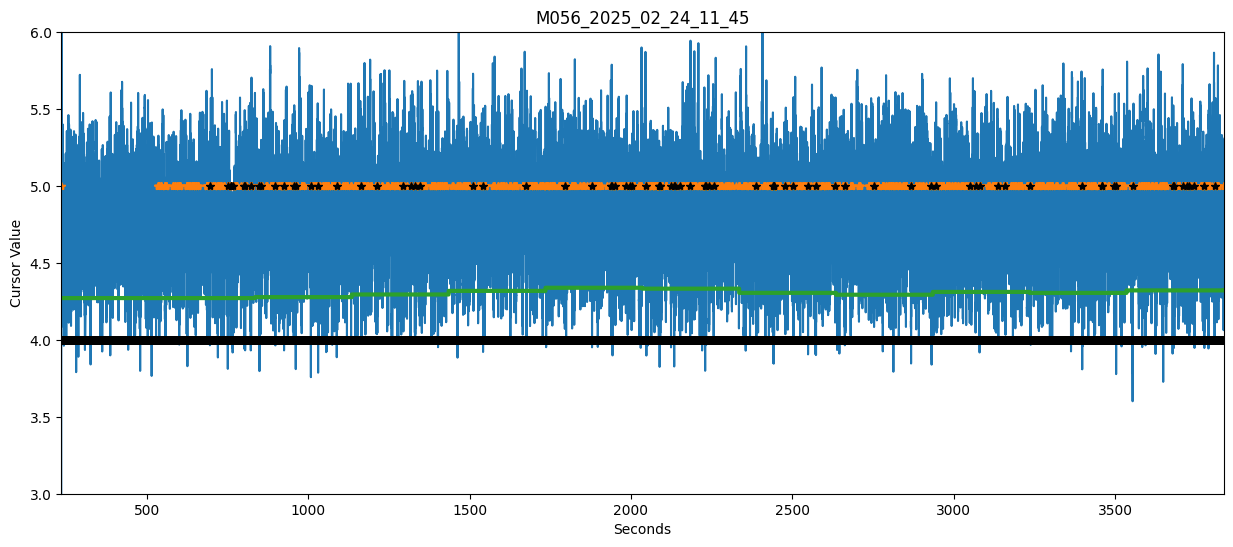

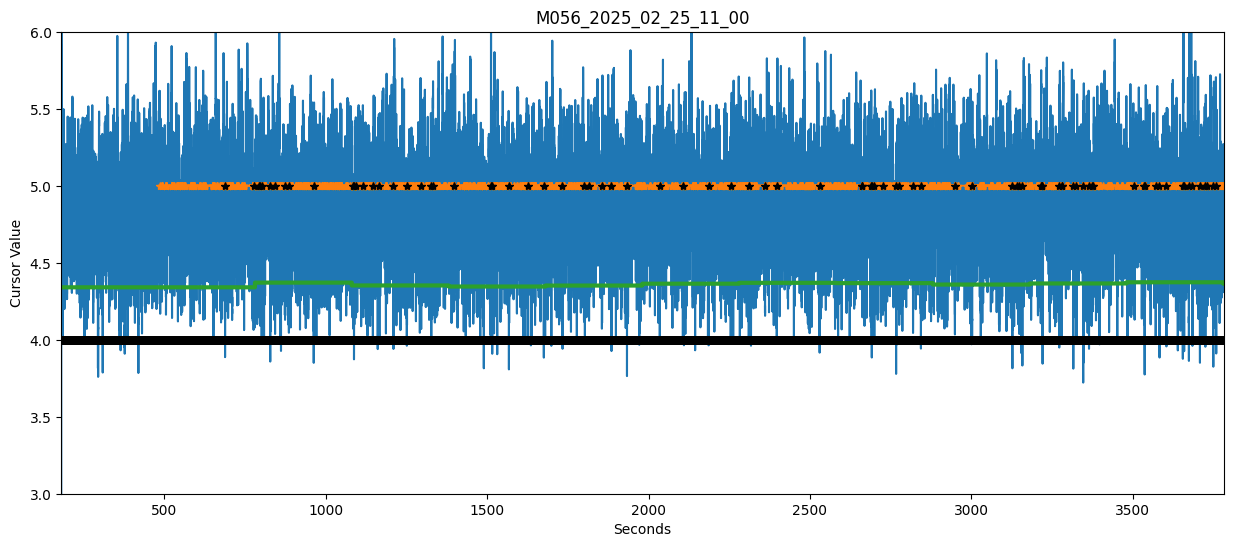

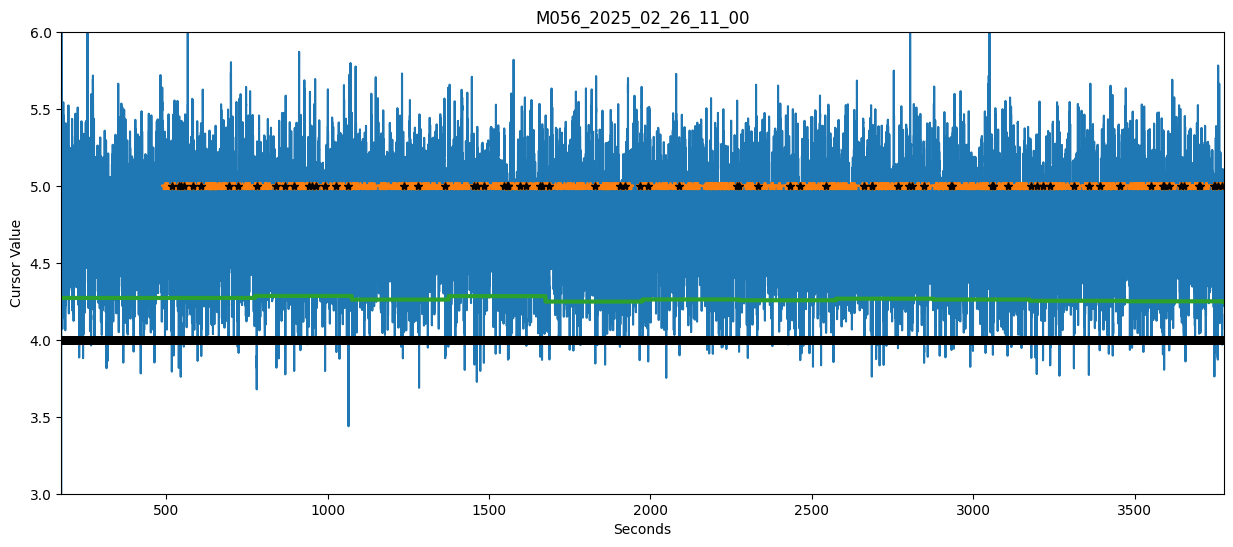

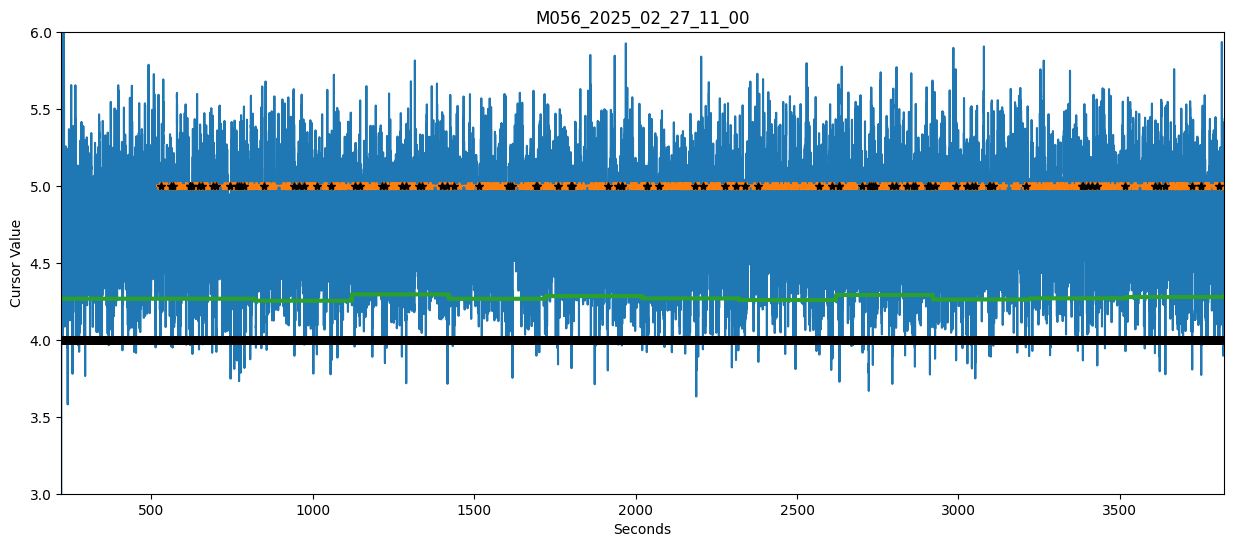

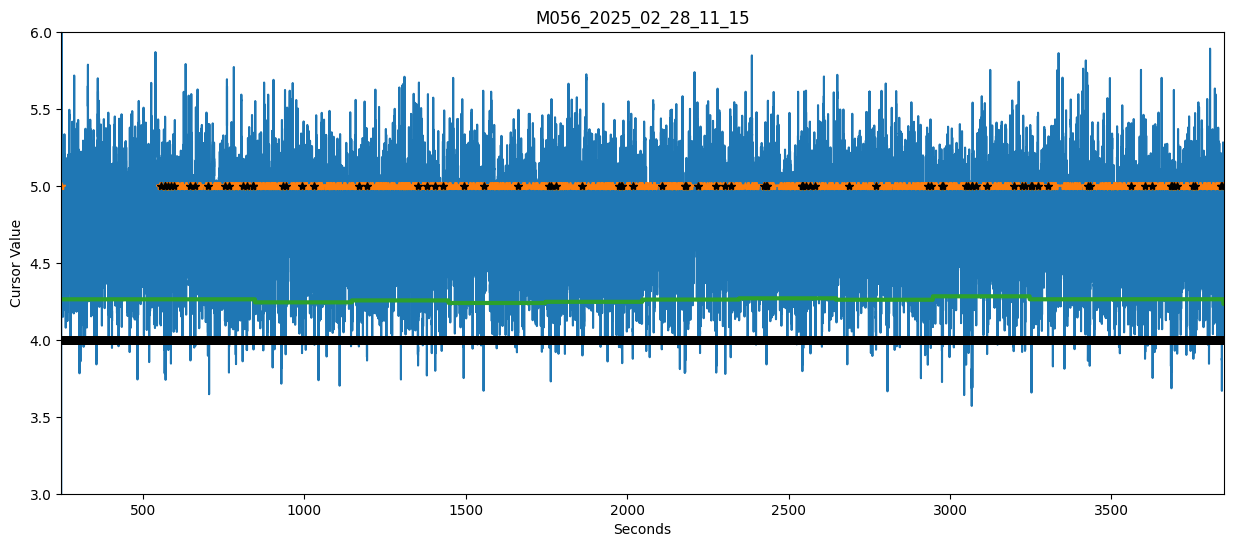

In [33]:
# Plot the cursor values
for session in range(len(session_logs)):
    min_v = time_cursor_all[session][0]
    max_v = time_cursor_all[session][0] + 3601
    plt.figure(figsize=(15, 6))
    plt.plot(time_cursor_all[session], cursor_all[session])
    plt.plot(time_cursor_all[session], bci_value_all[session] + 4, '*')
    plt.plot(time_cursor_all[session], th_value_all[session], linewidth=3) 
    plt.plot(time_cursor_all[session], rewarded_bci_value_all[session] + 4, 'k*')

    plt.title(session_logs[session][0])
    plt.xlabel('Seconds')
    plt.ylabel('Cursor Value')
    # Set x-axis limits
    plt.xlim(min_v, max_v)
    plt.ylim(3, 6)

    plt.show()

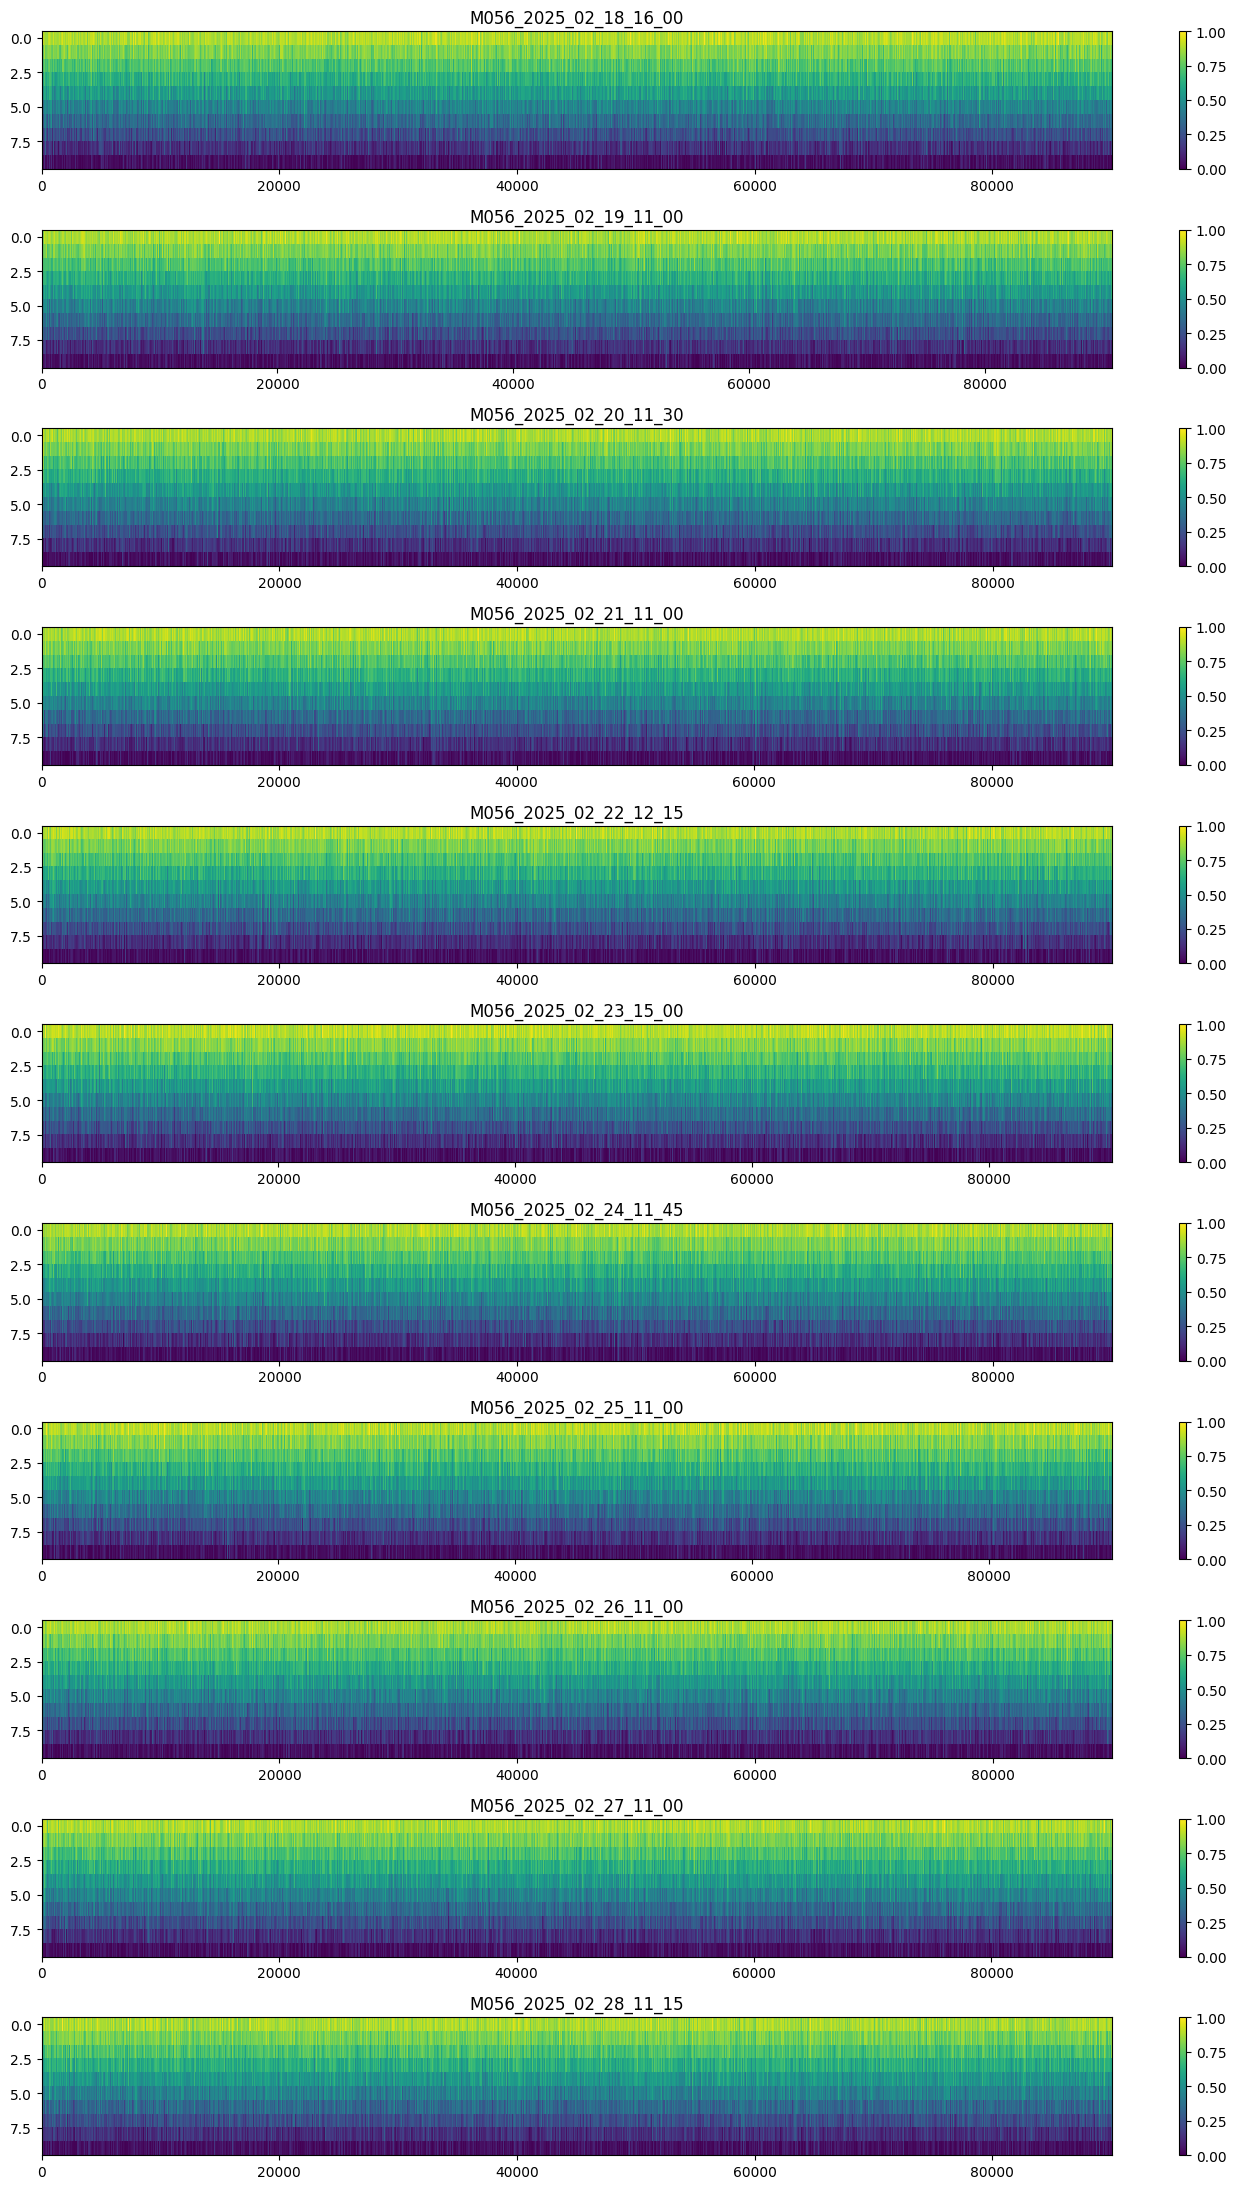

In [52]:
# ccs time change, individual session

fig, ax = plt.subplots(len(session_logs), 1, figsize=(14, len(session_logs)*2))

# Plot the cursor values
for session in range(len(session_logs)):
    min = time_cursor_all[session][0] + 300
    max = time_cursor_all[session][0] + 3601
    # ax[session].imshow(ccs_all[session].T, aspect='auto', cmap='viridis', interpolation='nearest')
    im = ax[session].imshow(ccs_all[session].T, aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    ax[session].set_title(session_logs[session][0])
    fig.colorbar(im, ax=ax[session])

# plt.ylabel('ccs')
plt.tight_layout() 
plt.show()

In [35]:
# # weight matrix change, individual session

# fig, ax = plt.subplots(len(session_logs), 12, figsize=(20, len(session_logs)*2))

# # Plot the cursor values
# for session in range(len(session_logs)):
#     pca1 = pca1_all[session]
#     for i in range(len(pca1)):
#         im = ax[session,i].imshow(pca1[i], aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)

#     # fig.colorbar(im, ax=ax[session])

# # plt.ylabel('ccs')
# plt.tight_layout() 
# plt.show()

In [36]:
ccs1_all = []
ccs2_all = []
# cca = CCA(n_components=10)
for session in range(len(session_logs)):
    pca1 = pca1_all[session]
    ccs1 = np.zeros([len(pca1),len(pca1)])
    pca2 = pca2_all[session]
    ccs2 = np.zeros([len(pca2),len(pca2)])
    for i in range(len(pca1)):
        for j in range(len(pca1)):
            # ccs[i,j] = np.mean(cca.fit(pca1[i],pca1[j]).coef_)
            A,B,r,U,V = matlab_cca.canoncorr(pca1[i], pca1[j], fullReturn = True)
            ccs1[i,j] = np.mean(r)
            
            A,B,r,U,V = matlab_cca.canoncorr(pca2[i], pca2[j], fullReturn = True)
            ccs2[i,j] = np.mean(r)
            
    ccs1_all.append(ccs1)
    ccs2_all.append(ccs2)

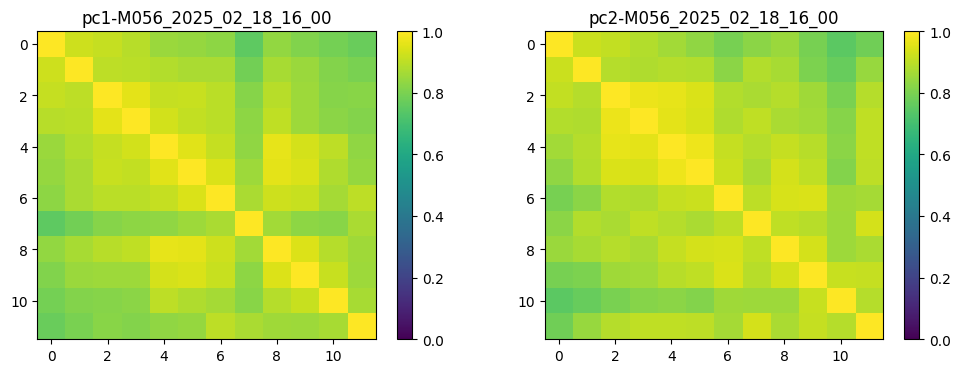

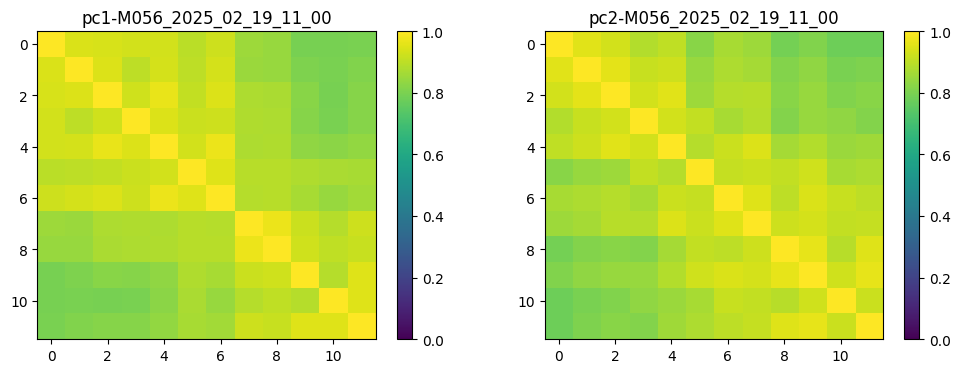

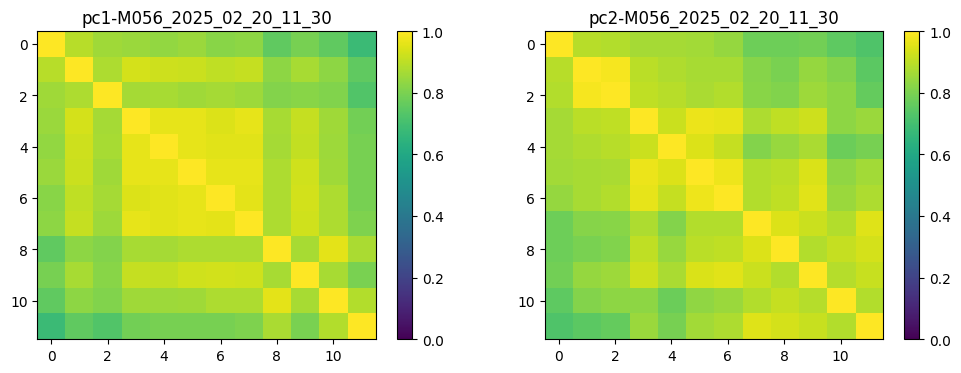

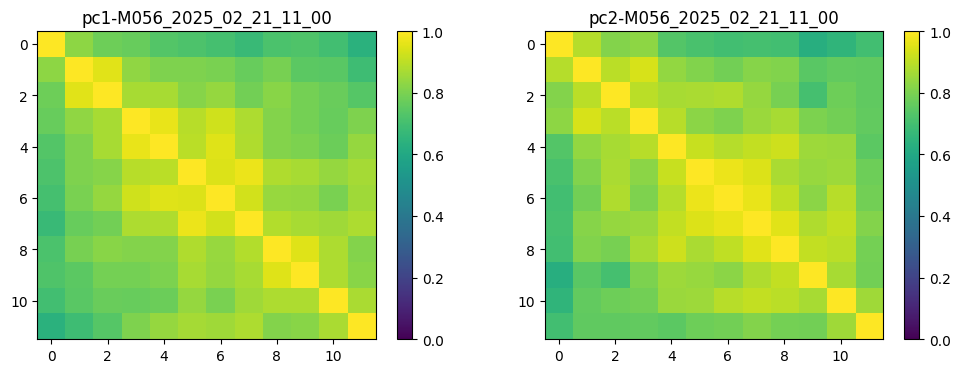

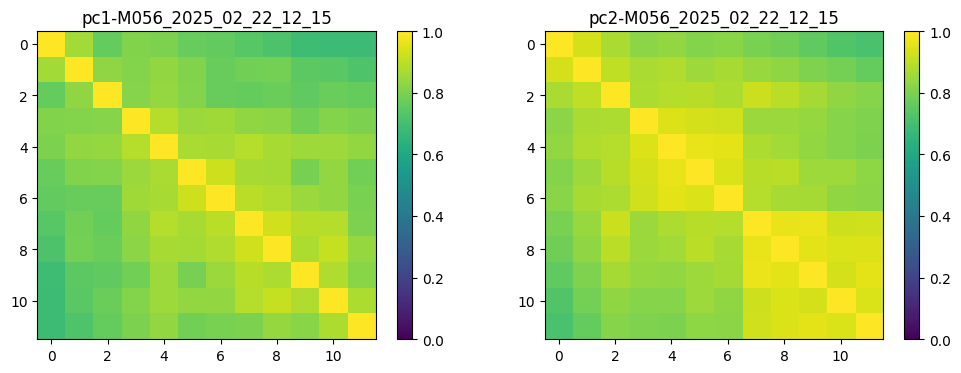

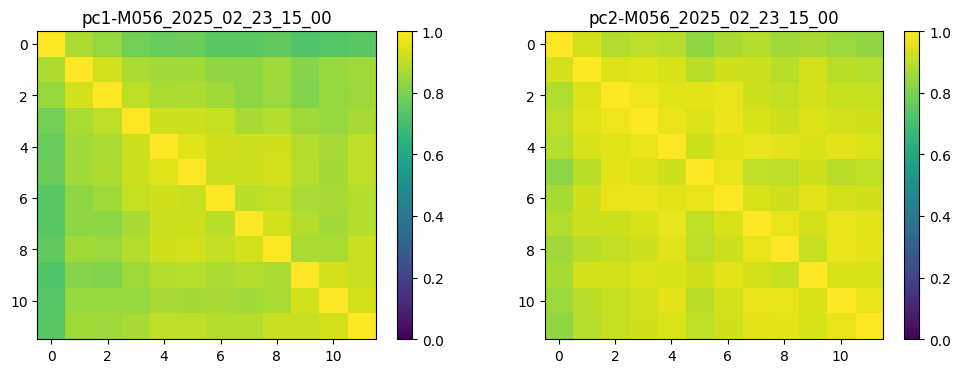

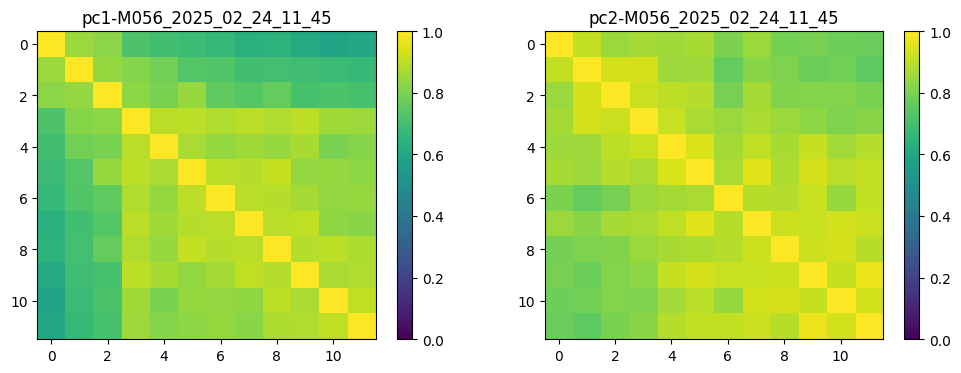

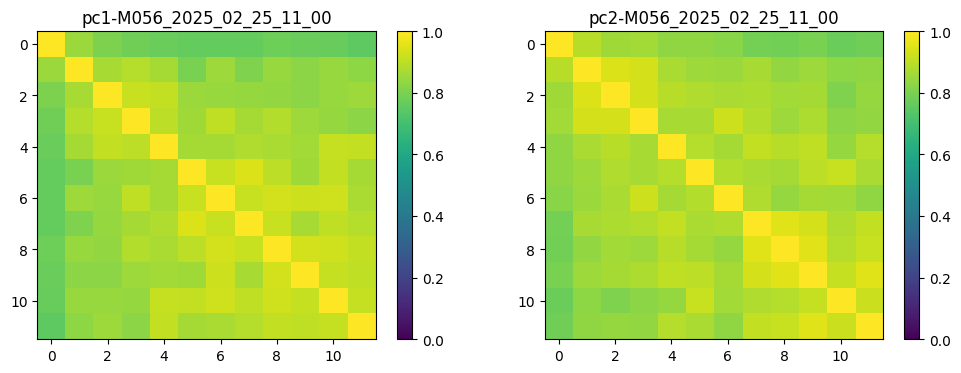

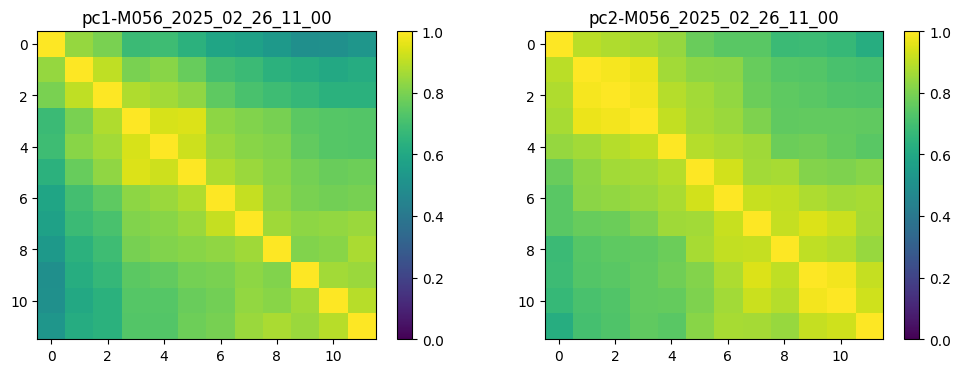

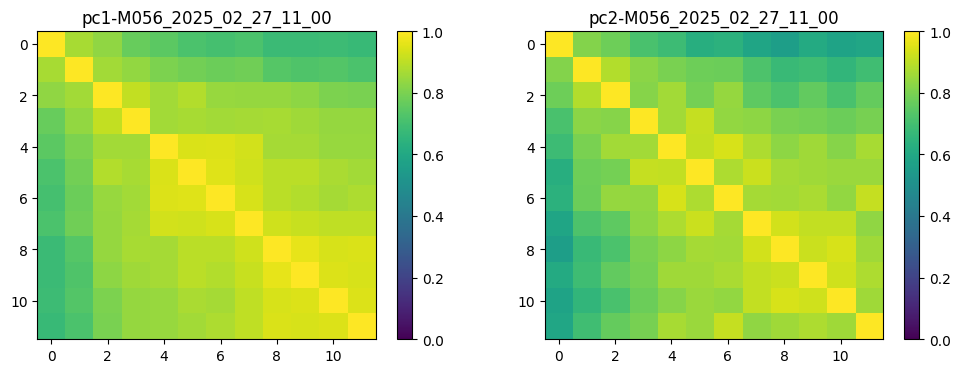

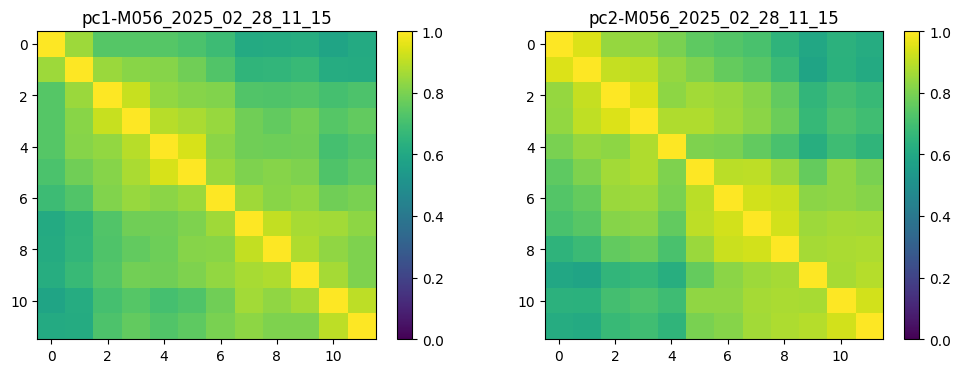

In [37]:
for session in range(len(session_logs)):     
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    im0 = ax[0].imshow(ccs1_all[session], aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    ax[0].set_title("pc1-" + session_logs[session][0])
    im1 = ax[1].imshow(ccs2_all[session], aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    ax[1].set_title("pc2-" + session_logs[session][0])
    
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im1, ax=ax[1])

How does the threshold change affect rewards?

In [38]:
# For each session, get the moment of threshold change and the time to the next reward
th_change_all = []
time_to_reward_all = []
for session in range(len(session_logs)):
    th_change = []
    time_to_reward = []
    for i in range(1, len(th_value_all[session])):
        if th_value_all[session][i] != th_value_all[session][i-1]:
            # Get the change in threshold value
            th_change.append(th_value_all[session][i]-th_value_all[session][i-1])
            # Get the time to the next time rewarded_bci_value_all is true
            for j in range(i, len(rewarded_bci_value_all[session])):
                if rewarded_bci_value_all[session][j] == 1:
                    time_to_reward.append(time_cursor_all[session][j] - time_cursor_all[session][i])
                    break
    # Fix for the last th change right before the end
    if len(th_change) > len(time_to_reward):
        th_change = th_change[:len(time_to_reward)]
        time_to_reward = time_to_reward[:len(time_to_reward)]
    
    th_change_all.append(th_change)
    time_to_reward_all.append(time_to_reward)                

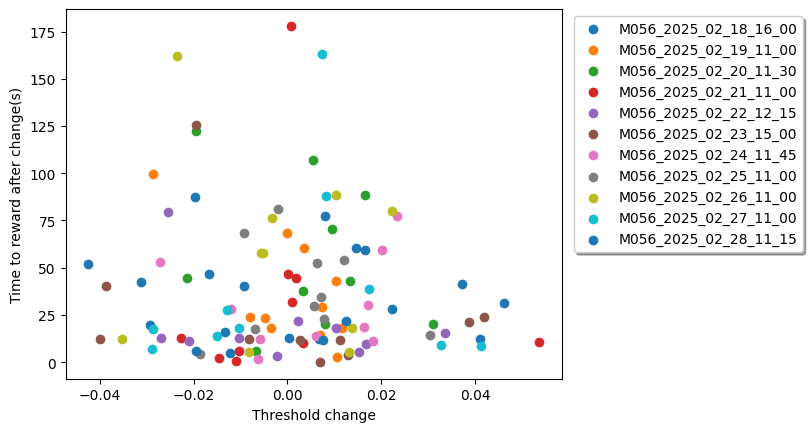

In [39]:
for session in range(len(th_change_all)):
    plt.scatter(th_change_all[session], time_to_reward_all[session], label=sessions[session])
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', shadow=True)

    plt.xlabel('Threshold change')  
    plt.ylabel('Time to reward after change(s)')

In [40]:
# For each session, get the threshold change and the change in reward rate for 2 accumulated minutes before and after
th_change_all = []
change_reward_rate_all = []
accum_samples = 120/0.04
for session in range(len(session_logs)):
    th_change = []
    change_reward_rate = []
    for i in range(1, len(th_value_all[session])):
        if th_value_all[session][i] != th_value_all[session][i-1]: # threshold change
            if i+accum_samples < len(rewarded_bci_value_all[session]): # check that there are enough samples after change
                # Get the change in reward rate for 2 accumulated minutes before and after
                pre_reward_rate = np.sum(rewarded_bci_value_all[session][int(i-accum_samples):i])
                post_reward_rate = np.sum(rewarded_bci_value_all[session][i:int(i+accum_samples)])
                change_reward_rate.append(post_reward_rate - pre_reward_rate)                
                # Get the change in threshold value
                th_change.append(th_value_all[session][i]-th_value_all[session][i-1])
            else:
                break
    th_change_all.append(th_change)
    change_reward_rate_all.append(change_reward_rate)    

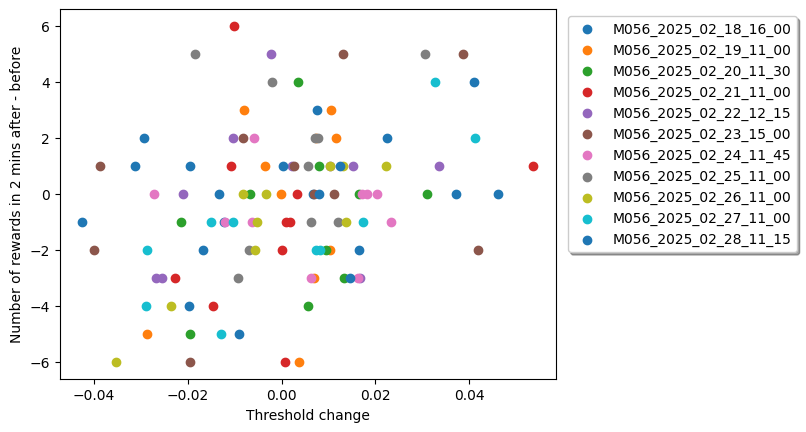

In [41]:
for session in range(len(th_change_all)):
    plt.scatter(th_change_all[session], change_reward_rate_all[session], label=sessions[session])
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', shadow=True)

    plt.xlabel('Threshold change')  
    plt.ylabel('Number of rewards in 2 mins after - before')

Look at in-session learning (i.e. compare the begining of the session with the end)

In [42]:
# # Maybe to begin with, plot ccs hist at first 25 min and last 25 mins of each session (in a separate plot), yeah, this is a lot of plots!
# # In minutes
# start_block = np.array([5,30])
# end_block = np.array([35,60])

# start_block = start_block*60/0.04
# end_block = end_block*60/0.04

# for session in range(len(session_logs)):
#     if len(cursor_all[session]) > end_block[1]:
#         plt.figure()
#         ccs_start = cursor_all[session][int(start_block[0]):int(start_block[1])]
#         ccs_end = cursor_all[session][int(end_block[0]):int(end_block[1])]
#         plt.hist(ccs_start, bins=150, alpha=0.5, label='start')
#         plt.hist(ccs_end, bins=150, alpha=0.5, label='end')
#         plt.legend(loc='upper right')
#         plt.title(session_logs[session][0])
#     else:
#         print('Ignoring ' + session_logs[session][0])
#         continue

what about holding times??

64
63
86
80
59
70
61
74
66


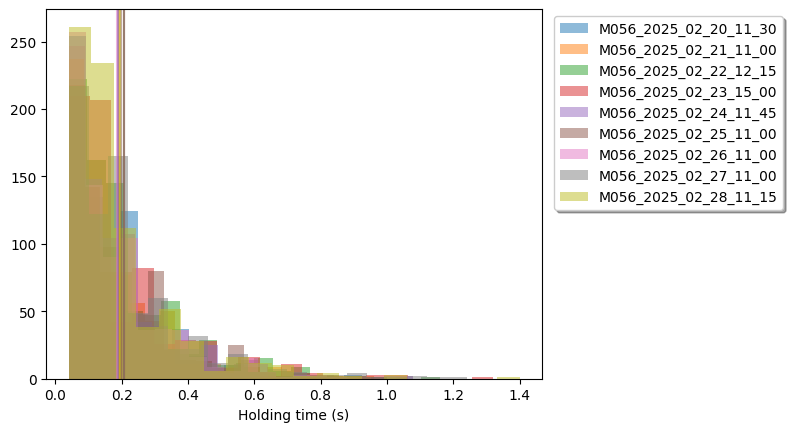

In [51]:
# Histogram of continuous cursor values==1 in each session
for session in range(len(session_logs)):
    if session <2:
        continue
    bci_value = bci_value_all[session]
    diff = np.diff(np.concatenate(([0], bci_value, [0])))
    holdings = np.where(diff == -1)[0] - np.where(diff == 1)[0]
    holdings = holdings*0.04 # to seconds
    hist = plt.hist(holdings, bins=20, alpha=0.5, label=sessions[session])
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', shadow=True)
    plt.xlabel('Holding time (s)')
    color = hist[2][0].get_facecolor()
    plt.axvline(x=np.mean(holdings),color=color)
    print(np.sum(holdings>0.4))

TO DO: (good idea) for each th crossing, get the cursor value (or threshold - cursor_value) and plt a histogram of the session

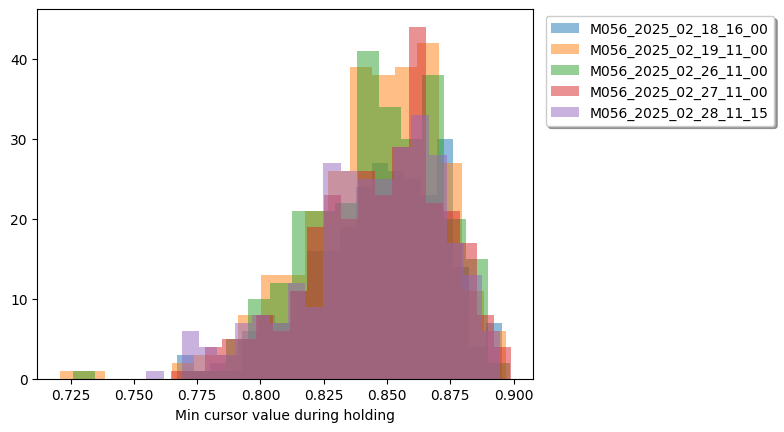

In [44]:
# Histogram of min ccs for each holding value higher than 200ms
min_holding = 0.2 #seconds
min_cc_all = []
for session in range(len(session_logs)):
    
    bci_value = bci_value_all[session]
    cursor = cursor_all[session]
    diff = np.diff(np.concatenate(([0], bci_value, [0])))
    start = np.where(diff == 1)[0]
    end = np.where(diff == -1)[0]   
    min_cc = [] 
    for i, j in zip(start, end):
        if j - i < min_holding / 0.04:
            continue
        min_cc.append(np.min(cursor[i:j])/np.mean(cursor))

    min_cc_all.append(min_cc)
       
    if (session<8)&(session>1):
        continue
    plt.hist(min_cc, bins=20, alpha=0.5, label=sessions[session])
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', shadow=True) 
    plt.xlabel('Min cursor value during holding') 
    
    

C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2116\2674235360.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Session", y="Min cursor value/mean cursor value", data=df_melted, inner="box", palette="coolwarm")


<Figure size 1000x500 with 0 Axes>

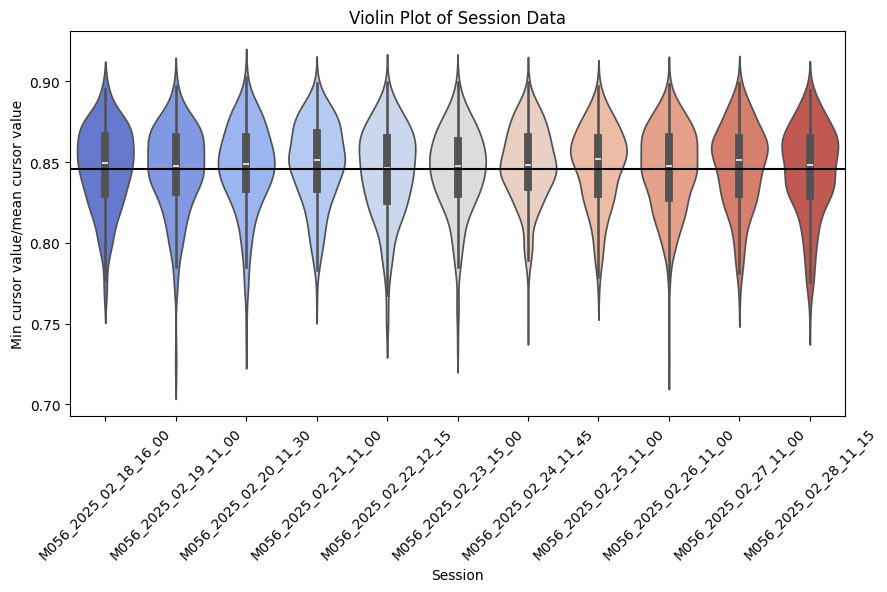

In [45]:
# violin plot
plt.figure(figsize=(10, 5))
max_length = max(len(sublist) for sublist in min_cc_all)
padded_data = [sublist + [np.nan] * (max_length - len(sublist)) for sublist in min_cc_all]
df = pd.DataFrame(padded_data).transpose()
df.columns = sessions
# Melt the DataFrame for Seaborn (long format required)
df_melted = df.melt(var_name="Session", value_name="Min cursor value/mean cursor value")

# Violin plot
plt.figure(figsize=(10, 5))
sns.violinplot(x="Session", y="Min cursor value/mean cursor value", data=df_melted, inner="box", palette="coolwarm")
plt.axhline(y=np.mean([item for sublist in min_cc_all for item in sublist]),color='k')
plt.xticks(rotation=45)
plt.title("Violin Plot of Session Data")
plt.show()

In [46]:
np.mean(np.mean(min_cc_all))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11,) + inhomogeneous part.

Numero de threshold crossings